In [1]:
using Plots
using DataStructures

┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1423


# 5. Monte Carlo Methods

Instead of computing $v_\pi$ using the given dynamics of an MDP, sample data to _estimate_ $v_\pi$ and use that estimate to perform policy iteration.

## 5.1  Monte Carlo Prediction

We need to learn $v_\pi(s)$ from samples of the MDP process with policy $\pi$.

We distinguish between two ways of estimating $v_\pi(s)$

1. Calculate the average return from trajectories after the _first_ occurrence of state $s$:

$$
\hat{v}_\pi(s) = \frac{1}{N}\sum_{n=1}^N{\sum_{i=k}^{T_n}{\gamma^{i-k}R^n_i}}
$$

Where $T_n$ is the length of episode $n$, and $k$ is the first index such that $S^n_k = s$

2. Calculate the average return from trajectories after _all_ occurences of state $s$

$$
\hat{v}_\pi(s) = \frac{1}{N(s)}\sum_{n,k}\sum_{i=k}^{T_n}{\gamma^{i-k}R^n_i}
$$

We can implement first visit Monte Carlo prediction with the following code

In [2]:
function first_visits(𝓢, S)
    d = Dict()
    for (i, s) in enumerate(S)
        if !haskey(d, s)
            d[s] = i
        end
        
        if length(d) == length(𝓢)
            return d
        end
    end
    return d
end

first_visits (generic function with 1 method)

In [3]:
using DataStructures

function first_visit_mc(𝓢, sampler; γ=1, iterations=1000)
    V = DefaultDict(0)
    N = DefaultDict(0)
    for n in 1:iterations
        S, A, R = sampler()
        visits = first_visits(𝓢, S)
        G = 0
        for i in length(S):-1:1
            G = γ*G + R[i]
            if haskey(visits, S[i]) && visits[S[i]] == i
                N[S[i]] += 1
                V[S[i]] += (1/N[S[i]])*(G - V[S[i]])
            end
        end
    end
    
    return V
end

first_visit_mc (generic function with 1 method)

### Example 5.1: Blackjack

In [98]:
function policy(s)
    hand, dealer, ace = s
    hand < 20 ? :hit : :stick
end

function rollout(π; initial_state = nothing)
    S = Tuple{Int,Int,Bool}[]
    A = Symbol[]
    R = Int64[]
    draw() = min(rand(1:13), 10)
    value(ace, hand) = (ace && hand <= 11) ? hand + 10 : hand 
    dealer = draw()
    hand = [draw(), draw()]
    has_ace = hand[1] == 1 || hand[2] == 1
    hand = sum(hand)

    dealer_hand = [dealer, draw()]
    dealer_has_ace = dealer_hand[1] == 1 || dealer_hand[2] == 1
    dealer_hand = sum(dealer_hand)
    while value(dealer_has_ace, dealer_hand) < 17
        card = draw()
        dealer_has_ace = dealer_has_ace || card == 1
        dealer_hand += card
    end
    dealer_total = value(dealer_has_ace, dealer_hand)

    # Get up to > 11
    while value(has_ace, hand) <= 11
        card = draw()
        has_ace = has_ace || card == 1
        hand += card
    end

    push!(S, (value(has_ace, hand), dealer, has_ace && hand <= 11))
    action = π(S[1])
    push!(A, action)
    while action == :hit && hand <= 21
        card = draw()
        has_ace = has_ace || card == 1
        hand += card
        if hand > 21
            push!(R, -1)
            return S, A, R
        end
        push!(R, 0)
        push!(S, (value(has_ace, hand), dealer, has_ace && hand <= 11))
        action = π(S[end])
        push!(A, action)
    end
    player_total = value(has_ace, hand)

    if (hand > 21 && dealer_hand > 21)
        push!(R, 0)
    elseif hand > 21
        push!(R, -1)
    elseif dealer_hand > 21
        push!(R, 1)
    elseif player_total == dealer_total
        push!(R, 0)
    elseif player_total < dealer_total
        push!(R, -1)
    else player_total > dealer_total
        push!(R, 1)
    end

    return S, A, R
end

rollout (generic function with 1 method)

In [101]:
rollout(policy)

(Tuple{Int64, Int64, Bool}[(20, 3, 0)], [:stick], [1])

In [102]:
𝓢 = [ (value, dealer, usable_ace) for value in 12:21, dealer in 1:10, usable_ace in [true, false]]

V1e4 = first_visit_mc(𝓢, () -> rollout(policy); γ=1, iterations=10_000)
V5e5 = first_visit_mc(𝓢, () -> rollout(policy); γ=1, iterations=500_000)

DefaultDict{Any, Any, Int64} with 200 entries:
  (20, 8, false)  => 0.789515
  (16, 10, false) => -0.687405
  (16, 2, false)  => -0.643154
  (19, 3, true)   => -0.454857
  (15, 9, false)  => -0.60185
  (19, 10, false) => -0.741644
  (19, 2, false)  => -0.721537
  (17, 3, false)  => -0.67888
  (17, 9, true)   => -0.344262
  (13, 7, true)   => -0.276956
  (12, 6, true)   => -0.121622
  (18, 10, true)  => -0.446738
  (18, 2, true)   => -0.463612
  (20, 8, true)   => 0.826353
  (16, 10, true)  => -0.421604
  (16, 2, true)   => -0.372131
  (20, 7, false)  => 0.7794
  (15, 3, false)  => -0.621594
  (15, 9, true)   => -0.314286
  (19, 10, true)  => -0.508261
  (19, 2, true)   => -0.471611
  (17, 3, true)   => -0.413076
  (13, 9, false)  => -0.555951
  (17, 10, false) => -0.705748
  (17, 2, false)  => -0.690643
  ⋮               => ⋮

In [103]:
ace_V1e4 = [ V1e4[(i, j, true)] for i in 12:21, j in 1:10 ]
noace_V1e4 = [ V1e4[(i, j, false)] for i in 12:21, j in 1:10 ]
ace_V5e5 = [ V5e5[(i, j, true)] for i in 12:21, j in 1:10 ]
noace_V5e5 = [ V5e5[(i, j, false)] for i in 12:21, j in 1:10 ];

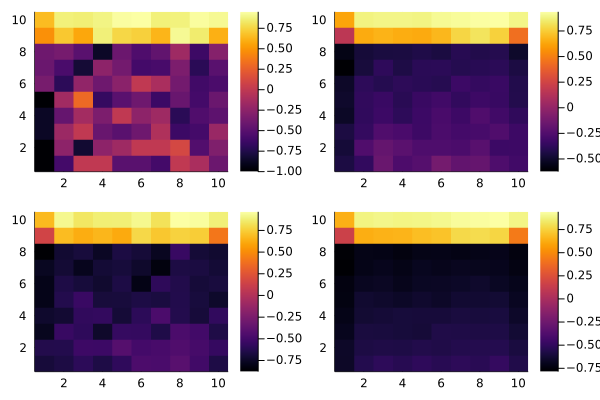

In [104]:
p1 = heatmap(ace_V1e4)
p2 = heatmap(noace_V1e4)
p3 = heatmap(ace_V5e5)
p4 = heatmap(noace_V5e5)

plot(p1, p3, p2, p4, layout=(2,2))

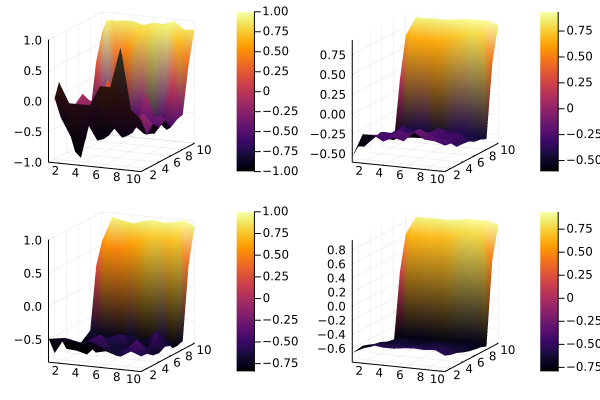

In [11]:
p1 = surface(ace_V1e4)
p2 = surface(noace_V1e4)
p3 = surface(ace_V5e5)
p4 = surface(noace_V5e5)

plot(p1, p3, p2, p4, layout=(2,2))

> _Exercise 5.1_ Consider the diagrams on the right in Figure 5.1. Why does the estimated value function jump up for the last two rows in the rear? Why does it drop off for the whole last row on the left? Why are the frontmost values higher in the upper diagrams than in the lower?

The estimated value function jumps for the last two rows since those two rows represent relatively high scores compared to the average dealer score, and additionally the policy "sticks" for these values, meaning we are likely to achieve those scores than busting.

The drop off on the left is because the dealer possesses an ace, which is a more valuable card since it can be used as either an 11 or a 1.

The value of the states in the bottom half of the figure are for the same reason. Having an ace allows you to "hit" more with less of a chance of busting.

> _Exercise 5.2_ Suppose every-visit MC was used instead of first-visit MC on the blackjack task. Would you expect the results to be very different? Why or why not?

I would not expect every-visit MC to be very different from the first-visit MC results. This is because the value of any state, as we have set it up here, is not affected by it's location in the sequence.

> _Exercise 5.3_ What is the backup diagram for Monte Carlo estimation of $q_\pi$?

The backup diagram for Monte Carlo $q_\pi$ estimation would be the same as the backup diagram for state-value estimation, since in either case we start with a particular state and action. In order to illustrate this one could somehow indicate that the initial state _and_ action are being evaluated, rather than just the particular state, perhaps by surrounding the state and action with a box.

> _Exercise 5.4_ The pseudocode for Monte Carlo ES is inefficient because, for each state–action pair, it maintains a list of all returns and repeatedly calculates their mean. It would be more efficient to use techniques similar to those explained in Section 2.4 to maintain just the mean and a count (for each state–action pair) and update them incrementally. Describe how the pseudocode would be altered to achieve this.

This can be achieved by simply mainting the current average values $Q(s, a)$, and the visit count to each state-action pair. Instead of recomputing the average, we compute:

$$
Q(s, a) \gets Q(s, a) + \frac{1}{N(s, a)}(G - Q(s, a))
$$

In [12]:
function first_visits(𝓢, 𝓐, S, A)
    visits = Dict()
    for i in eachindex(S)
        if !haskey(visits, (S[i], A[i]))
            visits[(S[i], A[i])] = i
        end
        
        if length(visits) == length(𝓢)*length(𝓐)
            return visits
        end
    end
    return visits
end

function monte_carlo_es(𝓢, 𝓐, init_sampler, sampler, π_init; γ=1, iterations=10000)
    π_dict = π_init
    π(s) = π_dict[s]
    Q = Dict((s, a) => 0.0 for s in 𝓢, a in 𝓐)
    N = Dict((s, a) => 0.0 for s in 𝓢, a in 𝓐)
    
    for i in 1:iterations
        s0, a0 = init_sampler()
        S, A, R = sampler(π, s0, a0)
        visits = first_visits(𝓢, 𝓐, S, A)
        G = 0
        for i in length(S):-1:1
            G = γ*G + R[i]
            if visits[(S[i], A[i])] == i
                N[S[i], A[i]] += 1
                Q[S[i], A[i]] += 1/(N[S[i], A[i]]) * (G - Q[S[i], A[i]])
                π_dict[S[i]] = argmax(a -> Q[S[i], a], 𝓐)
            end
        end
    end
    
    return Q, π_dict
end

π_init = Dict(s => policy(s) for s in 𝓢)
𝓐 = [:hit, :stick]

init_sampler() = (rand(𝓢), rand(𝓐))

function rollout_es(π, s0, a0)
    S = Tuple{Int,Int,Bool}[]
    A = Symbol[]
    R = Int64[]
    draw() = min(rand(1:13), 10)
    value(ace, hand) = (ace && hand <= 11) ? hand + 10 : hand 
    
    init_value, dealer, usable_ace = s0
    if usable_ace
        hand = init_value - 10
    else
        hand = init_value
    end
    has_ace = usable_ace
    
    dealer_hand = [dealer, draw()]
    dealer_has_ace = dealer_hand[1] == 1 || dealer_hand[2] == 1
    dealer_hand = sum(dealer_hand)
    while value(dealer_has_ace, dealer_hand) < 17
        card = draw()
        dealer_has_ace = dealer_has_ace || card == 1
        dealer_hand += card
    end
    dealer_total = value(dealer_has_ace, dealer_hand)
    
    push!(S, s0)
    push!(A, a0)
    
    action = a0
    while action == :hit && hand <= 21
        card = draw()
        has_ace = has_ace || card == 1
        hand += card
        if hand > 21
            push!(R, -1)
            return S, A, R
        end
        push!(R, 0)
        push!(S, (value(has_ace, hand), dealer, has_ace && hand <= 11))
        action = π(S[end])
        push!(A, action)
    end
    player_total = value(has_ace, hand)

    if (hand > 21 && dealer_hand > 21)
        push!(R, 0)
    elseif hand > 21
        push!(R, -1)
    elseif dealer_hand > 21
        push!(R, 1)
    elseif player_total == dealer_total
        push!(R, 0)
    elseif player_total < dealer_total
        push!(R, -1)
    else player_total > dealer_total
        push!(R, 1)
    end

    return S, A, R
end

rollout_es (generic function with 1 method)

In [57]:
Q, π_star = monte_carlo_es(𝓢, 𝓐, init_sampler, rollout_es, π_init; γ=1, iterations=5e6);

In [58]:
V = Dict(s => Q[s, π_star[s]] for s in 𝓢)

Dict{Tuple{Int64, Int64, Bool}, Float64} with 200 entries:
  (20, 8, 0)  => 0.793944
  (16, 10, 0) => -0.569619
  (19, 3, 1)  => 0.407222
  (16, 2, 0)  => -0.286585
  (15, 9, 0)  => -0.473966
  (19, 10, 0) => -0.0184416
  (19, 2, 0)  => 0.379789
  (17, 9, 1)  => -0.149936
  (13, 7, 1)  => 0.123462
  (17, 3, 0)  => -0.107959
  (12, 6, 1)  => 0.184956
  (18, 10, 1) => -0.197265
  (18, 2, 1)  => 0.109702
  (20, 8, 1)  => 0.793086
  (16, 10, 1) => -0.251341
  (16, 2, 1)  => -0.0178033
  (20, 7, 0)  => 0.773199
  (15, 9, 1)  => -0.111047
  (15, 3, 0)  => -0.254067
  (19, 10, 1) => -0.017356
  (19, 2, 1)  => 0.388517
  (17, 3, 1)  => 0.0242266
  (13, 9, 0)  => -0.383888
  (17, 10, 0) => -0.466222
  (17, 2, 0)  => -0.158008
  ⋮           => ⋮

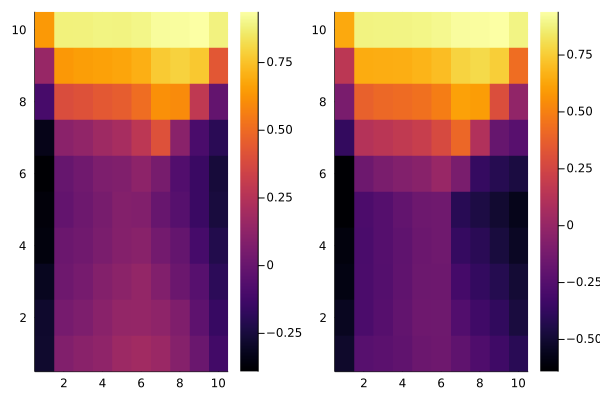

In [59]:
ace_V = [ V[(i, j, true)] for i in 12:21, j in 1:10 ]
noace_V = [ V[(i, j, false)] for i in 12:21, j in 1:10 ];

p3 = heatmap(ace_V)
p4 = heatmap(noace_V)

plot(p3, p4, layout=(1,2))

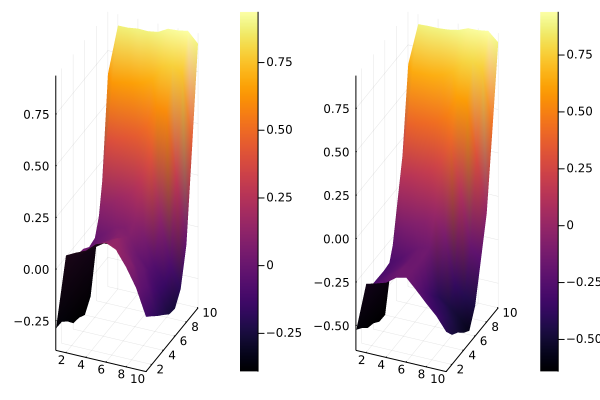

In [60]:
p1 = surface(ace_V)
p2 = surface(noace_V)

plot(p1, p2, layout=(1, 2))

In [87]:
ace_π = [ π_star[(i, j, true)] for i in 12:21, j in 1:10 ]
noace_π = [ π_star[(i, j, false)] for i in 12:21, j in 1:10 ];

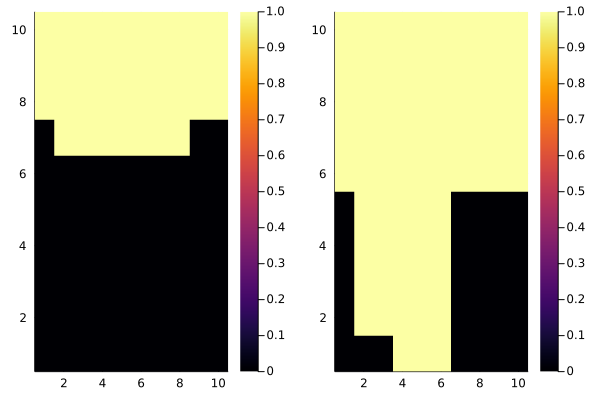

In [88]:
p1 = heatmap(ace_π .== :stick)
p2 = heatmap(noace_π .== :stick)

plot(p1, p2, layout=(1, 2))

In [89]:
function monte_carlo_es_epsilon_greedy(𝓢, 𝓐, sampler, π_init; γ=1, iterations=10000, ε=0.05)
    π_dict = π_init
    π(s) = rand() < ε ? rand(𝓐) : π_dict[s]
    Q = Dict((s, a) => 0.0 for s in 𝓢, a in 𝓐)
    N = Dict((s, a) => 0.0 for s in 𝓢, a in 𝓐)
    
    for i in 1:iterations
        S, A, R = sampler(π)
        visits = first_visits(𝓢, 𝓐, S, A)
        G = 0
        for i in length(S):-1:1
            G = γ*G + R[i]
            if visits[(S[i], A[i])] == i
                N[S[i], A[i]] += 1
                Q[S[i], A[i]] += 1/(N[S[i], A[i]]) * (G - Q[S[i], A[i]])
                π_dict[S[i]] = argmax(a -> Q[S[i], a], 𝓐)
            end
        end
    end
    
    return Q, π_dict
end

monte_carlo_es_epsilon_greedy (generic function with 1 method)

In [90]:
Q, π_dict = monte_carlo_es_epsilon_greedy(𝓢, 𝓐, rollout, π_init; γ=1, iterations=5e7)

(Dict{Tuple{Tuple{Int64, Int64, Bool}, Symbol}, Float64}(((14, 7, 0), :hit) => -0.3352932834436958, ((16, 7, 0), :stick) => -0.46943784032518054, ((19, 8, 1), :stick) => 0.5945115142598136, ((19, 5, 1), :hit) => 0.1990147783251234, ((20, 9, 0), :hit) => -0.8524156614848708, ((15, 10, 1), :hit) => -0.23608714310497364, ((19, 7, 0), :stick) => 0.6147890131565262, ((15, 2, 1), :hit) => -0.005119114375124305, ((13, 3, 1), :hit) => 0.06586458241854781, ((17, 8, 0), :stick) => -0.38162024124169347…), Dict{Tuple{Int64, Int64, Bool}, Symbol}((20, 8, 0) => :stick, (16, 10, 0) => :hit, (19, 3, 1) => :stick, (16, 2, 0) => :stick, (13, 6, 1) => :hit, (15, 9, 0) => :hit, (19, 10, 0) => :stick, (19, 2, 0) => :stick, (17, 9, 1) => :hit, (13, 7, 1) => :hit…))

In [91]:
ace_π_eps = [ π_star[(i, j, true)] for i in 12:21, j in 1:10 ]
noace_π_eps = [ π_star[(i, j, false)] for i in 12:21, j in 1:10 ];

In [92]:
ace_π_eps

10×10 Matrix{Symbol}:
 :hit    :hit    :hit    :hit    :hit    …  :hit    :hit    :hit    :hit
 :hit    :hit    :hit    :hit    :hit       :hit    :hit    :hit    :hit
 :hit    :hit    :hit    :hit    :hit       :hit    :hit    :hit    :hit
 :hit    :hit    :hit    :hit    :hit       :hit    :hit    :hit    :hit
 :hit    :hit    :hit    :hit    :hit       :hit    :hit    :hit    :hit
 :hit    :hit    :hit    :hit    :hit    …  :hit    :hit    :hit    :hit
 :hit    :stick  :stick  :stick  :stick     :stick  :stick  :hit    :hit
 :stick  :stick  :stick  :stick  :stick     :stick  :stick  :stick  :stick
 :stick  :stick  :stick  :stick  :stick     :stick  :stick  :stick  :stick
 :stick  :stick  :stick  :stick  :stick     :stick  :stick  :stick  :stick

In [93]:
noace_π_eps

10×10 Matrix{Symbol}:
 :hit    :hit    :hit    :stick  :stick  …  :hit    :hit    :hit    :hit
 :hit    :stick  :stick  :stick  :stick     :hit    :hit    :hit    :hit
 :hit    :stick  :stick  :stick  :stick     :hit    :hit    :hit    :hit
 :hit    :stick  :stick  :stick  :stick     :hit    :hit    :hit    :hit
 :hit    :stick  :stick  :stick  :stick     :hit    :hit    :hit    :hit
 :stick  :stick  :stick  :stick  :stick  …  :stick  :stick  :stick  :stick
 :stick  :stick  :stick  :stick  :stick     :stick  :stick  :stick  :stick
 :stick  :stick  :stick  :stick  :stick     :stick  :stick  :stick  :stick
 :stick  :stick  :stick  :stick  :stick     :stick  :stick  :stick  :stick
 :stick  :stick  :stick  :stick  :stick     :stick  :stick  :stick  :stick

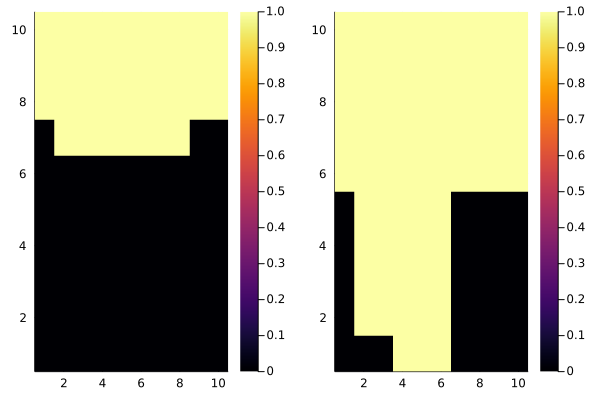

In [94]:
p1 = heatmap(ace_π_eps .== :stick)
p2 = heatmap(noace_π_eps .== :stick)

plot(p1, p2, layout=(1, 2))

## 5.5 Importance Sampling

> _Exercise 5.5_ Consider an MDP with a single nonterminal state and a single action that transitions back to the nonterminal state with probability p and transitions to the terminal state with probability $1 - p$. Let the reward be $+1$ on all transitions, and let $\gamma = 1$. Suppose you observe one episode that lasts 10 steps, with a return of 10. What are the first-visit and every-visit estimators of the value of the nonterminal state?

The first-visit estimator will be $10$, since the expected future reward from the _first_ visit to the nonterminal state resulted in a total return of $10$. However, the every-visit estimator will estimate the value of the state as:

$$
V(s) = \frac{1}{10}\sum_{i=1}^{10}{i} = 5.5
$$

Since it observes each of $1, 2\dots10$ as a return for the nonterminal state.

**Example 5.4: Off-policy estimation of a Blackjack State Value**



> _Exercise 5.6_ What is the equation analagous to (5.6) for _action_ values $Q(s, a)$ instead of state values $V(s)$, again given returns generated using $b$?

$$
Q(s, a) = \frac{\sum_{t\in\mathcal{T}(s, a)}\rho_{t+1:T-1}G_t}{\sum_{t\in\mathcal{T}(s, a)}{\rho'_{t+1:T-1}}}
$$

Where $\mathcal T(s, a)$ denotes the visits (either first or every) the the state action pair $(s, a)$.

> _Exercise 5.7_ In learning curves such as those shown in Figure 5.3 error generally decreases with training, as indeed happened for the ordinary importance-sampling method. But for the weighted importance-sampling method error first increased and then decreased. Why do you think this happened?

This likely happened because the weighted importance sampling method has bias for sample sizes less that $\infty$. For example, it could be that:

$$
\mathbb{E}\Bigg[\frac{\sum_{t\in\mathcal{T}(s)}\rho_{t:T(t)-1}G_t}{\sum_{t\in\mathcal{T}(s)}\rho_{t:T(t)-1}}\Bigg] \approx 0.5 \neq v_\pi(s)
$$

> _Exercise 5.8_ The results with Example 5.5 and shown in Figure 5.4 used a first-visit MC method. Suppose that instead an every-visit MC method was used on the same problem. Would the variance of the estimator still be infinite? Why or why not?

$$
\begin{align*}
\mathbb{E}[\hat{V}(s)] &= \sum_{\tau}{P(\tau|b)\left(\frac{1}{T-1}\sum_{i=1}^{T-1}{\prod_{t=i}^{T-1}{\frac{\pi(A_t|S_t)}{b(A_t|S_t)}G_t}}\right)^2}\\\\
&= \frac{1}{2}0.1\left(\frac{1}{0.5}\right)^2 + \frac{1}{2}0.9\frac{1}{2}0.1\left(\frac{1}{2}\right)^2\left(\frac{1}{0.5} + \frac{1}{0.5}\frac{1}{0.5}\right)^2 + \dots\\\\
&= 0.1\sum_{i=1}\frac{0.9^{i-1}}{2^i i^2}(2^{i+1}-2)^2\\\\
&= 0.4\sum_{i=1}\frac{0.9^{i-1}}{2^i i^2}(2^{i}-1)^2\\\\
&= 0.4\sum_{i=1}\frac{0.9^{i-1}}{2^i i^2}(2^{2i} - 2^{i+1} + 1)\\\\
&= 0.4\sum_{i=1}0.9^{i-1}(\frac{2^{i}}{i^2} - \frac{2}{i^2} + 1)\\\\
&= \frac{4}{9}\sum_{i=1}0.9^{i}(\frac{2^{i}}{i^2} - \frac{2}{i^2} + 1)\\\\
&= \frac{4}{9}\sum_{i=1}\frac{1.8^{i}}{i^2} - \frac{2\cdot0.9^i}{i^2} + 0.9^i\\\\
&= \frac{4}{9}\left(\sum_{i=1}\frac{1.8^{i}}{i^2} - 2\sum_{i=1}\frac{0.9^i}{i^2} + \sum_{i=1}0.9^i\right)\\\\
&= \infty
\end{align*}
$$

## 5.6 Incremental Implementation

> _Exercise 5.9_ Modify the algorithm for first-visit MC policy evaluation (Section 5.1) to use the incremental implementation for sample averages described in Section 2.4.

✅

> _Exercise 5.10_ Derive the weighted-average update rule (5.8) from (5.7). Follow the pattern of the derivation of the unweighted rule (2.3).

Note that $C_n = \sum_{k=1}^{n}{W_k}$

$$
\begin{align*}
V_{n+1} &= \frac{\sum_{k=1}^{n}{W_k G_k}}{\sum_{k=1}^{n}{W_k}}\\\\
&= \frac{1}{\sum_{k=1}^{n}{W_k}}\big(W_n G_n + \sum_{k=1}^{n-1}{W_k G_k}\big)\\\\
&= \frac{1}{C_n}\big(W_n G_n + C_{n-1}V_n\big)\\\\
&= \frac{W_n G_n}{C_n} + \frac{C_n - W_n}{C_n}V_n\\\\
&= \frac{W_n G_n}{C_n} + V_n - \frac{W_n}{C_n}V_n\\\\
&= V_n + \frac{W_n}{C_n}(G_n - V_n)
\end{align*}
$$

## 5.7 Off-policy Monte Carlo Control

> _Exercise 5.11_ In the boxed algorithm for off-policy MC control, you may have been expecting the $W$ update to have involved the importance-sampling ratio $\frac{\pi(A_t|S_t)}{b(A_t|S_t)}$, but instead it involves $\frac{1}{b(A_t|S_t)}$. Why is this nevertheless correct?

Because of the guard before this line, we know that $\pi(S_t) = A_t$. Conceptually, this is identical to a distribution $\pi(A_t | S_t) = 1$, so this component of the importance sampling ratio will always be $\frac{\pi(A_t | S_t}{b(A_t | S_t)} = \frac{1}{b(A_t | S_t)}$.

> _Exercise 5.12: Racetrack (programming)_ Consider driving a race car around a turn like those shown in Figure 5.5. You want to go as fast as possible, but not so fast as to run off the track. In our simplified racetrack, the car is at one of a discrete set of grid positions, the cells in the diagram. The velocity is also discrete, a number of grid cells moved horizontally and vertically per time step. The actions are increments to the velocity components. Each may be changed by +1, -1, or 0 in each step, for a total of nine ($3 \times 3$) actions. Both velocity components are restricted to be nonnegative and less than 5, and they cannot both be zero except at the starting line. Each episode begins in one of the randomly selected start states with both velocity components zero and ends when the car crosses the finish line. The rewards are -1 for each step until the car crosses the finish line. If the car hits the track boundary, it is moved back to a random position on the starting line, both velocity components are reduced to zero, and the episode continues. Before updating the car’s location at each time step, check to see if the projected path of the car intersects the track boundary. If it intersects the finish line, the episode ends; if it intersects anywhere else, the car is considered to have hit the track boundary and is sent back to the starting line. To make the task more challenging, with probability 0.1 at each time step the velocity increments are both zero, independently of the intended increments. Apply a Monte Carlo control method to this task to compute the optimal policy from each starting state. Exhibit several trajectories following the optimal policy (but turn the noise off for these trajectories).

In [21]:
𝓐 = [ (i, j) for i in -1:1, j in -1:1]

3×3 Matrix{Tuple{Int64, Int64}}:
 (-1, -1)  (-1, 0)  (-1, 1)
 (0, -1)   (0, 0)   (0, 1)
 (1, -1)   (1, 0)   (1, 1)

In [34]:
starting, finishing, boundary = course1
locations = cat(starting, finishing, boundary; dims=1)
velocities = [ (i, j) for i in 0:4, j in 0:4 if i != 0 ||  j != 0 ]
    
𝓢 = cat(
    [ (location..., velocity...) for location in locations, velocity in velocities if true],
    [ (location..., 0, 0) for location in starting ];
    dims=1
);

In [23]:
function rollout_racecar(course, policy)
    starting, finishing, boundary = course
    locations = cat(starting, finishing, boundary; dims=1)
    velocities = [ (i, j) for i in 0:4, j in 0:4 if i != 0 ||  j != 0 ]
    
    𝓢 = cat(
        [ (location..., velocity...) for location in locations, velocity in velocities if true],
        [ (location..., 0, 0) for location in starting ];
        dims=1
    )
    
    S = []
    A = []
    R = []
    S_current = (rand(starting)..., 0, 0)
    A_current = policy(S_current)
    R_current = -1
    done = false
    while !done
        push!(S, S_current)
        push!(A, A_current)
        push!(R, -1)
        
        x, y, vx, vy = S_current
        nx = x + vx
        ny = y + vy

        ax, ay = A_current
        nvx = clamp(vx + ax, 0, 4)
        nvy = clamp(vy + ay, 0, 4)
            
        if (nx, ny) ∉ locations
            nx, ny = rand(starting)
            nvx, nvy = (0, 0)
        end

        if vx != 0
            for xp in x:nx
                yp = vx == 0 ? y : y + floor((vy/vx)*(xp - x))
                if (xp, yp) ∈ finishing
                    done = true
                end
                if (xp, yp) ∉ locations
                    nx, ny = rand(starting)
                    nvx, nvy = (0, 0)
                end
            end
        elseif vy != 0
            for yp in y:ny
                if (x, yp) ∈ finishing
                    done = true
                end
                if (x, yp) ∉ locations
                    nx, ny = rand(starting)
                    nvx, nvy = (0, 0)
                end
            end
        end
        S_current = (nx, ny, nvx, nvy)
        A_current = policy(S_current)
    end
    
    return S, A, R
end

rollout_racecar (generic function with 1 method)

In [24]:
function racer_policy(s)
    x, y, vx, vy = s
    if rand() < 0.1
        return rand(𝓐)
    elseif y > 17
        return (1, -1)
    else
        return (0, 1)
    end
end

racer_policy (generic function with 1 method)

In [25]:
function racer_dist(a, s)
    x, y, vx, vy = s
    a_det = y > 17 ? (1, -1) : (0, 1)
    if a == a_det
        return 0.9 + 0.1/length(𝓐)
    else
        return 0.1 / length(𝓐)
    end
end
    

racer_dist (generic function with 1 method)

In [33]:
course1 = (
    [(x, 1) for x in 4:9],
    [(17, y) for y in 27:32],
    cat(
        [(x, y) for x in 4:9, y in 2:32 if true],
        [(x, y) for x in 10:16, y in 27:32 if true],
        [(3, y) for y in 4:31],
        [(2, y) for y in 11:29],
        [(1, y) for y in 19:28],
        [(10, 26)]; dims = 1
    )
)

([(4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1)], [(17, 27), (17, 28), (17, 29), (17, 30), (17, 31), (17, 32)], [(4, 2), (5, 2), (6, 2), (7, 2), (8, 2), (9, 2), (4, 3), (5, 3), (6, 3), (7, 3)  …  (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 28), (10, 26)])

In [27]:
S, A, R = rollout_racecar(course1, racer_policy)

(Any[(9, 1, 0, 0), (9, 1, 0, 1), (9, 2, 0, 2), (9, 4, 0, 3), (9, 7, 0, 4), (9, 11, 0, 4), (9, 15, 0, 4), (9, 19, 0, 4), (9, 23, 1, 3), (10, 26, 2, 2)  …  (7, 4, 0, 3), (7, 7, 0, 4), (7, 11, 0, 4), (7, 15, 0, 4), (7, 19, 0, 4), (7, 23, 0, 3), (7, 26, 1, 2), (8, 28, 2, 1), (10, 29, 3, 0), (13, 29, 4, 0)], Any[(0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (1, -1), (1, -1), (1, -1)  …  (0, 1), (0, 1), (0, 1), (0, 1), (0, -1), (1, -1), (1, -1), (1, -1), (1, -1), (1, 1)], Any[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1  …  -1, -1, -1, -1, -1, -1, -1, -1, -1, -1])

In [45]:
using WGLMakie
using Makie

function plot_course(course)
    start, finish, other = course
    fig = Figure(resolution=(1080, 1920))
    
    for (x, y) in start
        Box(fig[end-y, x], color=RGBf(0.0, 1.0, 0.0), height=50, width=50)
    end
    
    for (x, y) in finish
        Box(fig[end-y, x], color=:red, height=50, width=50, padding=0.0)
    end
    
    for (x, y) in other
        Box(fig[end-y, x], color=:gray)
    end
    
    fig
end

plot_course(course1)

In [31]:
function off_policy_mc_control(𝓢, 𝓐, b, b_dist; γ, iterations, course)
    Q = Dict((s, a) => 0.0 for s in 𝓢, a in 𝓐)
    C = Dict((s, a) => 0.0 for s in 𝓢, a in 𝓐)
    π_dict = Dict(s => rand(𝓐) for s in 𝓢)
    
    for n in 1:iterations
        G = 0
        W = 1
        println("Iteration $(n)")
        
        S, A, R = rollout_racecar(course, b)
        println(length(S))
        for t in length(S):-1:1
            G = γ*G + R[t]
            C[(S[t], A[t])] += W
            Q[(S[t], A[t])] += W/C[(S[t],A[t])] * (G - Q[(S[t], A[t])])
            println("Adding something")
            π_dict[S[t]] = argmax(a -> Q[(S[t], a)], 𝓐)
            if A[t] != π_dict[S[t]]
                println("Breaking")
                break
            end
            W *= 1/b_dist(A[t], S[t])
        end
    end
    
    return Q, s -> argmax(a -> Q[(s, a)], 𝓐)
end

off_policy_mc_control (generic function with 1 method)

In [36]:
Q, π_racecar = off_policy_mc_control(𝓢, 𝓐, racer_policy, racer_dist; γ=0.99, iterations=1000, course=course1)

Iteration 1
25
Adding something
Breaking
Iteration 2
89
Adding something
Breaking
Iteration 3
419
Adding something
Breaking
Iteration 4
49
Adding something
Breaking
Iteration 5
72
Adding something
Breaking
Iteration 6
36
Adding something
Breaking
Iteration 7
136
Adding something
Breaking
Iteration 8
53
Adding something
Breaking
Iteration 9
89
Adding something
Breaking
Iteration 10
71
Adding something
Breaking
Iteration 11
54
Adding something
Breaking
Iteration 12
37
Adding something
Breaking
Iteration 13
309
Adding something
Breaking
Iteration 14
177
Adding something
Breaking
Iteration 15
46
Adding something
Breaking
Iteration 16
38
Adding something
Breaking
Iteration 17
199
Adding something
Breaking
Iteration 18
107
Adding something
Breaking
Iteration 19
26
Adding something
Breaking
Iteration 20
173
Adding something
Breaking
Iteration 21
200
Adding something
Breaking
Iteration 22
114
Adding something
Breaking
Iteration 23
67
Adding something
Breaking
Iteration 24
129
Adding something


Iteration 240
25
Adding something
Breaking
Iteration 241
12
Adding something
Breaking
Iteration 242
122
Adding something
Breaking
Iteration 243
23
Adding something
Breaking
Iteration 244
146
Adding something
Breaking
Iteration 245
129
Adding something
Breaking
Iteration 246
38
Adding something
Breaking
Iteration 247
43
Adding something
Breaking
Iteration 248
96
Adding something
Breaking
Iteration 249
39
Adding something
Breaking
Iteration 250
208
Adding something
Breaking
Iteration 251
133
Adding something
Breaking
Iteration 252
12
Adding something
Breaking
Iteration 253
118
Adding something
Breaking
Iteration 254
36
Adding something
Breaking
Iteration 255
69
Adding something
Breaking
Iteration 256
14
Adding something
Breaking
Iteration 257
25
Adding something
Breaking
Iteration 258
35
Adding something
Breaking
Iteration 259
12
Adding something
Breaking
Iteration 260
53
Adding something
Breaking
Iteration 261
283
Adding something
Breaking
Iteration 262
43
Adding something
Breaking
Iter

285
Adding something
Breaking
Iteration 477
52
Adding something
Breaking
Iteration 478
36
Adding something
Breaking
Iteration 479
158
Adding something
Breaking
Iteration 480
56
Adding something
Breaking
Iteration 481
12
Adding something
Breaking
Iteration 482
131
Adding something
Breaking
Iteration 483
33
Adding something
Breaking
Iteration 484
26
Adding something
Breaking
Iteration 485
41
Adding something
Breaking
Iteration 486
102
Adding something
Breaking
Iteration 487
32
Adding something
Breaking
Iteration 488
285
Adding something
Breaking
Iteration 489
49
Adding something
Breaking
Iteration 490
24
Adding something
Breaking
Iteration 491
174
Adding something
Breaking
Iteration 492
317
Adding something
Breaking
Iteration 493
34
Adding something
Breaking
Iteration 494
78
Adding something
Breaking
Iteration 495
78
Adding something
Breaking
Iteration 496
12
Adding something
Breaking
Iteration 497
45
Adding something
Breaking
Iteration 498
137
Adding something
Breaking
Iteration 499
12


Iteration 713
239
Adding something
Breaking
Iteration 714
124
Adding something
Breaking
Iteration 715
180
Adding something
Breaking
Iteration 716
36
Adding something
Breaking
Iteration 717
65
Adding something
Breaking
Iteration 718
37
Adding something
Breaking
Iteration 719
116
Adding something
Breaking
Iteration 720
29
Adding something
Breaking
Iteration 721
252
Adding something
Breaking
Iteration 722
63
Adding something
Breaking
Iteration 723
71
Adding something
Breaking
Iteration 724
108
Adding something
Breaking
Iteration 725
118
Adding something
Breaking
Iteration 726
25
Adding something
Breaking
Iteration 727
70
Adding something
Breaking
Iteration 728
216
Adding something
Breaking
Iteration 729
37
Adding something
Breaking
Iteration 730
139
Adding something
Breaking
Iteration 731
55
Adding something
Breaking
Iteration 732
363
Adding something
Breaking
Iteration 733
12
Adding something
Breaking
Iteration 734
182
Adding something
Breaking
Iteration 735
161
Adding something
Breaking

152
Adding something
Breaking
Iteration 950
12
Adding something
Breaking
Iteration 951
13
Adding something
Breaking
Iteration 952
25
Adding something
Breaking
Iteration 953
87
Adding something
Breaking
Iteration 954
25
Adding something
Breaking
Iteration 955
67
Adding something
Breaking
Iteration 956
39
Adding something
Breaking
Iteration 957
43
Adding something
Breaking
Iteration 958
12
Adding something
Breaking
Iteration 959
102
Adding something
Breaking
Iteration 960
85
Adding something
Breaking
Iteration 961
82
Adding something
Breaking
Iteration 962
85
Adding something
Breaking
Iteration 963
13
Adding something
Breaking
Iteration 964
55
Adding something
Breaking
Iteration 965
14
Adding something
Breaking
Iteration 966
12
Adding something
Breaking
Iteration 967
88
Adding something
Breaking
Iteration 968
70
Adding something
Breaking
Iteration 969
146
Adding something
Breaking
Iteration 970
75
Adding something
Breaking
Iteration 971
65
Adding something
Breaking
Iteration 972
12
Addin

(Dict(((17, 29, 0, 1), (0, -1)) => 0.0, ((9, 29, 2, 1), (-1, 1)) => 0.0, ((8, 12, 1, 0), (-1, -1)) => 0.0, ((9, 27, 4, 1), (-1, 0)) => 0.0, ((9, 14, 4, 1), (-1, -1)) => 0.0, ((1, 23, 0, 1), (-1, 0)) => 0.0, ((3, 30, 3, 2), (0, -1)) => 0.0, ((7, 21, 1, 3), (-1, 0)) => 0.0, ((6, 26, 4, 4), (-1, 0)) => 0.0, ((10, 26, 0, 2), (1, 0)) => 0.0…), var"#87#93"{Matrix{Tuple{Int64, Int64}}, Dict{Tuple{NTuple{4, Int64}, Tuple{Int64, Int64}}, Float64}}([(-1, -1) (-1, 0) (-1, 1); (0, -1) (0, 0) (0, 1); (1, -1) (1, 0) (1, 1)], Dict(((17, 29, 0, 1), (0, -1)) => 0.0, ((9, 29, 2, 1), (-1, 1)) => 0.0, ((8, 12, 1, 0), (-1, -1)) => 0.0, ((9, 27, 4, 1), (-1, 0)) => 0.0, ((9, 14, 4, 1), (-1, -1)) => 0.0, ((1, 23, 0, 1), (-1, 0)) => 0.0, ((3, 30, 3, 2), (0, -1)) => 0.0, ((7, 21, 1, 3), (-1, 0)) => 0.0, ((6, 26, 4, 4), (-1, 0)) => 0.0, ((10, 26, 0, 2), (1, 0)) => 0.0…)))

In [46]:
maximum(values(Q))

0.0